In this assignment we will construct a neural network that can transform a complex data distribution into a simple Gaussian. See the code that comes with the textbook at github.com. The dataset use for this assignment is created by the make_moons function from the Python library sklearn.

To build a custom Coupling layer for our example, stack Dense layers to create the scale output and a different set of Dense layers to create the translation output.
Then build a RealNVP network, as a custom Keras Model.
Train the network for 600 epochs.
For the submission, provide the loss curve for the training process and compare and describe your results with the ones in the book.

🧪 Assignment 5 – Normalizing Flow Models

In this hands-on assignment, you’ll build a custom RealNVP network to transform a complex dataset (generated using make_moons from sklearn) into a simple Gaussian distribution.

Key Tasks:

Create a custom Coupling Layer using separate sets of Dense layers for scale and translation outputs.
Build a RealNVP model as a custom Keras Model.
Train the network for 600 epochs.
Submission Requirements:

Include the training loss curve.
Provide a comparison and description of your results with those presented in the textbook.
📎 Reference code is available on the textbook’s companion GitHub repository.

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    regularizers,
    metrics,
    optimizers,
    callbacks,
)
import tensorflow_probability as tfp

In [3]:
COUPLING_DIM = 256
COUPLING_LAYERS = 2
INPUT_DIM = 2
REGULARIZATION = 0.01
BATCH_SIZE = 256
EPOCHS = 600

Load data

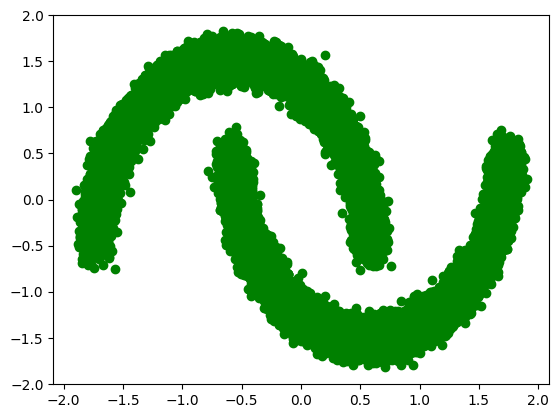

In [4]:
# Load the data
data = datasets.make_moons(30000, noise=0.05)[0].astype("float32")
norm = layers.Normalization()
norm.adapt(data)
normalized_data = norm(data)
plt.scatter(
    normalized_data.numpy()[:, 0], normalized_data.numpy()[:, 1], c="green"
)
plt.show()

Affin Coupling Layer

In [5]:
# creating the custom layer with keras API
output_dim = 256
reg = 0.01

def Coupling(input_dim, coupling_dim, reg):
    input_layer = layers.Input(shape=(input_dim,))

    s_layer_1 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input_layer)
    s_layer_2 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_1)
    s_layer_3 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_2)
    s_layer_4 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_3)
    s_layer_5 = layers.Dense(
        input_dim, activation="tanh", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_4)

    t_layer_1 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input_layer)
    t_layer_2 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_1)
    t_layer_3 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_2)
    t_layer_4 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_3)
    t_layer_5 = layers.Dense(
        input_dim, activation="linear", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_4)

    return models.Model(inputs=input_layer, outputs=[s_layer_5, t_layer_5])

Real NVP

In [6]:
class RealNVP(models.Model):
    def __init__(
        self, input_dim, coupling_layers, coupling_dim, regularization
    ):
        super(RealNVP, self).__init__()
        self.coupling_layers = coupling_layers
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc=[0.0, 0.0], scale_diag=[1.0, 1.0]
        )
        self.masks = np.array(
            [[0, 1], [1, 0]] * (coupling_layers // 2), dtype="float32"
        )
        self.loss_tracker = metrics.Mean(name="loss")
        self.layers_list = [
            Coupling(input_dim, coupling_dim, regularization)
            for i in range(coupling_layers)
        ]

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, x, training=True):
        log_det_inv = 0
        direction = 1
        if training:
            direction = -1
        for i in range(self.coupling_layers)[::direction]:
            x_masked = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            s, t = self.layers_list[i](x_masked)
            s *= reversed_mask
            t *= reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s))
                + x_masked
            )
            log_det_inv += gate * tf.reduce_sum(s, axis=1)
        return x, log_det_inv

    # Log likelihood of the normal distribution plus the log determinant of the jacobian.
    def log_loss(self, x):
        y, logdet = self(x)
        log_likelihood = self.distribution.log_prob(y) + logdet
        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self.log_loss(data)
        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self.log_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


model = RealNVP(
    input_dim=INPUT_DIM,
    coupling_layers=COUPLING_LAYERS,
    coupling_dim=COUPLING_DIM,
    regularization=REGULARIZATION,
)

Model Training


In [7]:
# Compile and train the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001))
history = model.fit(
    normalized_data, batch_size=256, epochs=600, verbose=2, validation_split=0.2
)

Epoch 1/600
94/94 - 11s - 118ms/step - loss: 2.5869 - val_loss: 2.4434
Epoch 2/600
94/94 - 5s - 49ms/step - loss: 2.3731 - val_loss: 2.3223
Epoch 3/600
94/94 - 4s - 43ms/step - loss: 2.2426 - val_loss: 2.1803
Epoch 4/600
94/94 - 4s - 46ms/step - loss: 2.1291 - val_loss: 2.0898
Epoch 5/600
94/94 - 3s - 37ms/step - loss: 2.0667 - val_loss: 2.0306
Epoch 6/600
94/94 - 9s - 97ms/step - loss: 2.0307 - val_loss: 1.9887
Epoch 7/600
94/94 - 3s - 34ms/step - loss: 1.9991 - val_loss: 1.9631
Epoch 8/600
94/94 - 3s - 33ms/step - loss: 1.9726 - val_loss: 1.9349
Epoch 9/600
94/94 - 6s - 62ms/step - loss: 1.9407 - val_loss: 1.8829
Epoch 10/600
94/94 - 3s - 34ms/step - loss: 1.8668 - val_loss: 1.7970
Epoch 11/600
94/94 - 3s - 33ms/step - loss: 1.7885 - val_loss: 1.7627
Epoch 12/600
94/94 - 4s - 48ms/step - loss: 1.7700 - val_loss: 1.7515
Epoch 13/600
94/94 - 4s - 41ms/step - loss: 1.7617 - val_loss: 1.7702
Epoch 14/600
94/94 - 3s - 34ms/step - loss: 1.7615 - val_loss: 1.7471
Epoch 15/600
94/94 - 4s - 3

Performance Evaluations

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


(-2.0, 2.0)

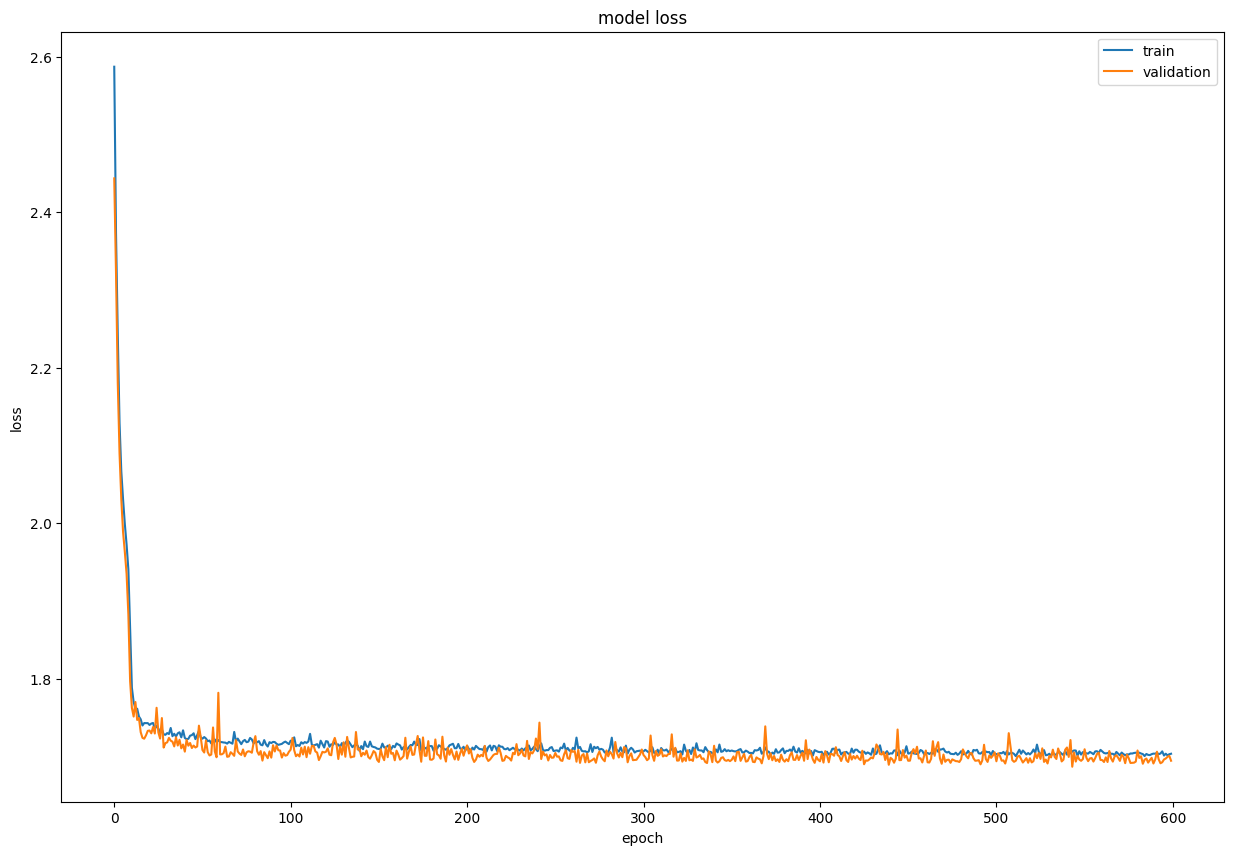

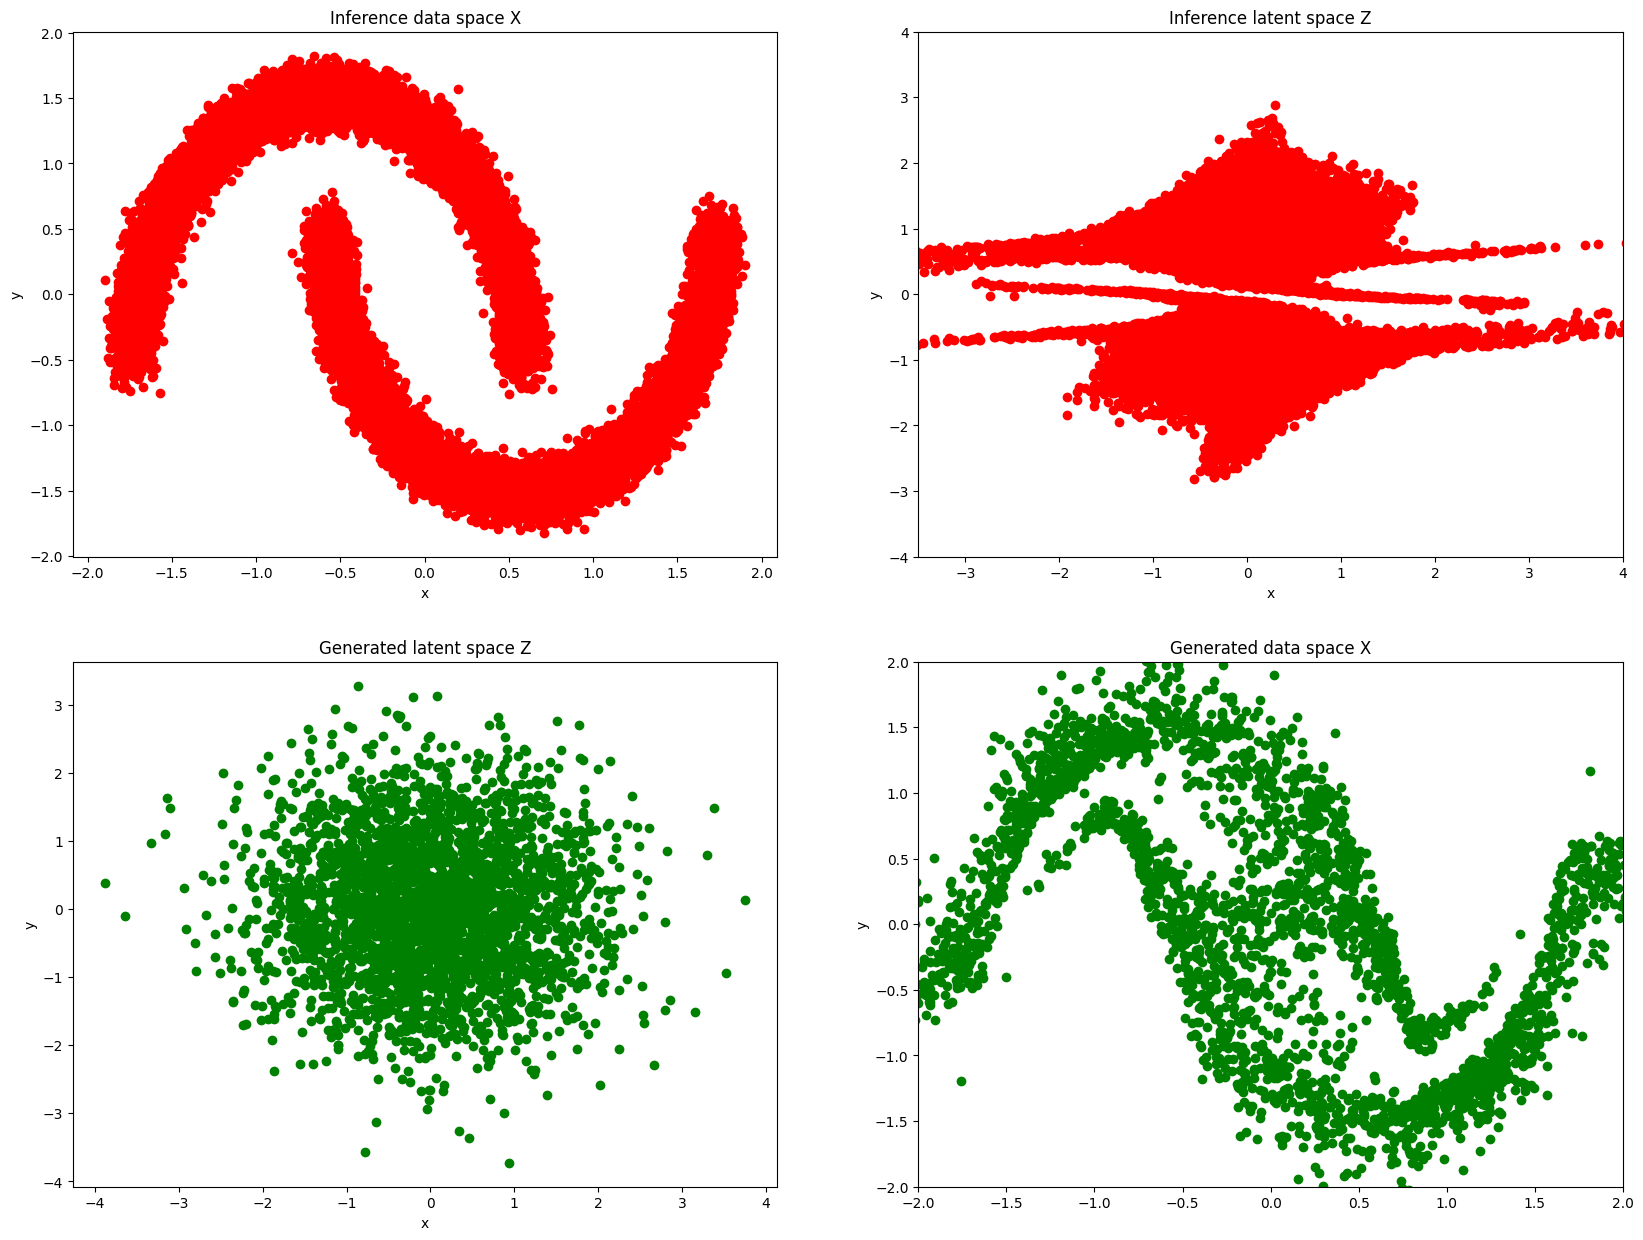

In [8]:
plt.figure(figsize=(15, 10))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.legend(["train", "validation"], loc="upper right")
plt.ylabel("loss")
plt.xlabel("epoch")

# From data to latent space.
z, _ = model(normalized_data)

# From latent space to data.
samples = model.distribution.sample(3000)
x, _ = model.predict(samples)

f, axes = plt.subplots(2, 2)
f.set_size_inches(20, 15)

axes[0, 0].scatter(normalized_data[:, 0], normalized_data[:, 1], color="r")
axes[0, 0].set(title="Inference data space X", xlabel="x", ylabel="y")
axes[0, 1].scatter(z[:, 0], z[:, 1], color="r")
axes[0, 1].set(title="Inference latent space Z", xlabel="x", ylabel="y")
axes[0, 1].set_xlim([-3.5, 4])
axes[0, 1].set_ylim([-4, 4])
axes[1, 0].scatter(samples[:, 0], samples[:, 1], color="g")
axes[1, 0].set(title="Generated latent space Z", xlabel="x", ylabel="y")
axes[1, 1].scatter(x[:, 0], x[:, 1], color="g")
axes[1, 1].set(title="Generated data space X", label="x", ylabel="y")
axes[1, 1].set_xlim([-2, 2])
axes[1, 1].set_ylim([-2, 2])